In [2]:
import gc

import joblib
import torch
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from cuml.cluster.hdbscan import (
    HDBSCAN,
    approximate_predict,
    all_points_membership_vectors,
)

# use rdkit to visual smiles
from rdkit import Chem
from rdkit.Chem import Draw

In [2]:
train_ds_file = "data/chem/isomer_design_test.parquet"
val_ds_file = "data/chem/isomer_design_val.parquet"
# model_name = "output/ChemBERTa-zinc-base--classification-model-epochs_2-mrl_dim_768-lr_7.70224078913779e-06-batch_size_312-warmup_steps_percent_2-scheduler_warmupcosine-dropout_p_0.25-loss_SoftMax"
model_name = "output/ChemBERTa-zinc-base--classification-model-epochs_3-mrl_dim_768-lr_3.4038386108141304e-06-batch_size_160-warmup_steps_percent_2-scheduler_warmupcosine-dropout_p_0.15-loss_SoftMax"
# model_name = "output/ChemBERTa-zinc-base-v1-2d-matryoshka-embeddings-n_layers_per_step_2-TaniLoss-lr_1.1190785944700813e-05-batch_size_8-num_epochs_2-epoch_2-best-model-1900000_steps"
# model_name = "output/ChemBERTa-zinc-base-v1-QED_functional_morgan_fingerprint-2d-matryoshka-embeddings-num_epochs_2-epoch_2-best-model-1900000_steps"
# model_name = "output/ChemBERTa-zinc-base-v1-QED_morgan_fingerprint-2d-matryoshka-embeddings-num_epochs_2-epoch_4-best-model-1900000_steps"
model_name_abbv = model_name[30:]

In [3]:
import pandas as pd
import cv2
import base64
import numpy as np


def update_width_and_height_to_isomer_design_df(ds_file):

    df = pd.read_parquet(ds_file)
    df["png_base64"] = df["png_2D"].str.strip("data:image/img;base64,")
    del df["png_base64"]
    # ex: 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAANQAAACXCAIAAADicOKNAAAACXBIWXMAAC4jAAAuIwF4pT92AAAAHXRFWHRTb2Z0d2FyZQBHUEwgR2hvc3RzY3JpcHQgOC43MQM/aDQAAAgnSURBVHic7d3PixNnGAfwJ603YeVdwS6F2jQ59eBBkoOw9pZF0B5EyB7s3oQZ25MXmfkPzF48tkzuvWRPHgqWyakVttAJbRFbWJmU3dLSizO62LKg9e3hlTEmM7P58c48yeT7OWlc9n3XfPO877ybeVKSUhIAh3e4JwDLC+EDNggfsEH4gA3CB2wQPmCD8AEbhA/YIHzABuEDNggfsEH4gA3CB2wQPmCD8AEbhA/YIHzABuEDNggfsEH4gE1hw2fb9s7ODvcsIE1hw9fr9Xq9HvcsIE1hwwfzD+EDNggfsEH4gA3CB2wQPmCD8AEbhA/YIHzABuEDNggfsEH4gA3CB2wQPmCD8AEbhA/YnOCeQFZu3LixtrbGPQtIU8LncACXAla+fw4f/vX7V0/+/oaITq9def+jz0+unOOeFMQo4J7vYK91cuXchUv7Fy7tn1w59/iXL7hnBPEKuOz+8O2HFy7tR389DB6srF5knA8kKWD4fvM+I6L3Prh+6vTFd0+c4p4OJCrgsvtx/evTa1eePXnwcPfTn7//5I/Hrf9ePstt9DAMbdsulUq2bYdhmNu4SrfbPXPmTLlc7na7OQ89DVloR//u9x/Zv/54PZ/hWq2WEEIIYVmW+oPjOPkM7ft+s9kkovX19fX1dSJqNpu+7+cz+nSKFr7d+2f/7H85+qCU8vDwMLtxXdetVCpEZFlWEARSyiAILMsiokaj4bpudkNHA1UqlWig0fnMoaKF72DvjsrfyxdPpZQvXzztP7L7j2wp5dbWVqfT0T5iVHIajcZopfE8r9FoEJFhGFnUIcdxVIlttVqj/6oKcKVSya0AT6Ro4ZNSHuzdebh7Zff+2d37Z3/67uLB3h0VxLt376qIeJ6nZaDYkiOl9DxvKGedTqdSqajlWMvQUkrXdWu12lBtC4JgqMoGQWAYht4fXJcChi+F67qqDs2+GKWUHFUIh4ZQSVV1aMYCnFJrPc8bfTHItwvw/KzCyxU+JX2pOlZsyUkaYmi9S1+jj5VUa8ccwnEc7QV4FssYPjneszhqouhEQ9RqtaEhxonvqImik3TBMd0PnpElDZ/i+75ajI49lZj6OUsZIqk6jop2C5MumtHRT1IBvn379uuHgkAahhRCEkkhpGHI7FfnpQ6fcuypxOyr1eAFR2wdGq2Oiu/7M14upJz4uK67tbWlvkgKIS1LqpeH70vLkkJknT+E77XYU4mpS076EEMXHLHVUeMFijz2xMcw5OjryrKkYcw4bjqE743BU4l79+5lcUKRcvAxWB0zujJIPPERQo4m0velEBpHH4XwDYuKRLlczuJQWqae+Khql92ZSHxBTfota8a/fUX44hFRtEPyfT+LHCSd+FiW1Wg0tA83KNpKvr7gYKp8BXxXi3amaW5vb2v/tmr7ZRiGbdvVajXP96Gora3rus+fPyciajap3R7+onabms1Mp1HAt9EvEFX2DMMwTXNjY0Pm+97KRqOhVn9qtahaJSIyDKpUqN+ndpvabfL9TCeAyscvOjtkm4EQ5PsUhlSvU6lE9TqFIfk+CZHpsKh8QEREQpDjkOPkOSYqH7BB+IANwgdsED5gg/ABG4QP2CB8wAbhAzYIH7BB+IANwgdsED5gg/ABG4QP2CB8wAbh49fv9zc3N0ulEvdE8obwcVJtTOv1eq/X63Q63NPJG97JfDx1m5n2b7uzs6Na5xqG0Wq1tH//BZDpvXFTU81EWPopRf0lLl++nFFb2ZSGZaqHUNa3Ts6JuQvfYEsejf0ixhS1Crh69Wpsd5UZDXYsGOqcMntbloUzX+EbvY86t6dktC3L4M39WtrKJvWM0tuWZYHMS/jSW0XpbdgzJD3fUa1KaiQ1jpSfbt4aNuaJP3zjN8nT/jyNX3KiXdqkny+Q0k8y01fUQuAM3xRFReMKNUWUJ/p8gZR+kku4vYvFFr5ZtlMzPnlRV9rpSk60dUtp6Rwle+hrlnZ7F4shfIMlZ5blZopla3ARnKXkpHfJVS+M0Vkt8/YuVq7hG4yLriO06Bl981Bye2EVF10lJynKrusOJRvbu1g5hS/TXY6qQ9FfUtoLT/fZB+nSg4XtXYrMwze4QuWxy2FqLzy6l8j7B19A2YZvxo9bmQZTk0359sXErVu3oo+fzHrcxZVt+LT/eup4TO2FI0EQXLt2bczjmCVXuE8aX10lz6NK5a0H+32q1ykI8plCt9vNv83oIirc+/mY2gvDFAr3fj6m9sIwhcJVPqb2wjCFwu355gD2fGMqXOWDxYHwARuED9ggfMAG4QM2CB+wQfiADcIHbBA+YIPwARuED9ggfMAG4dPv/Pnzrutyz2IB4F0twAaVT6swJNOk1VUqlWh1lUyTwpB7TvML4dMnDKlaJSHI80hK8jwSgqpV5C8Jll19TJOEoKEGt7ZNYUiOwzSnuYbw6TMHN84tFoRPn1KJYv8zkx5fetjz6SME9fvDD/b7uHcpCcKnwdHRERFuGZ5Y4e7bzV273X716tXNmzdxy/CkUPmmp26RNE2zXC4T4ZbhyfG1iVlg6LqnBZbdyYRhuL293W63hRCdTqeJ/dwMEL4J4NPS9MKebyy9Xm9jY2Nzc1Ots0ieFgjfMcIwNE2zXq8Tkeu6qv0t96QKAstuGtu21fbOcRx1hQEaIXzxBrd3qtMy94wKCL/bjVev12u1mmVZWGSzg/ABG1xwABuED9ggfMAG4QM2CB+wQfiADcIHbBA+YIPwARuED9ggfMAG4QM2CB+wQfiADcIHbBA+YIPwARuED9ggfMAG4QM2/wNrSrbdD9R0UgAAAABJRU5ErkJggg=='

    def readb64(uri):
        uri = uri.split(",")[1] # equiv. to .strip() above
        nparr = np.frombuffer(base64.b64decode(uri), np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        return img

    df["width"] = 0
    df["height"] = 0
    for i, row in df.iterrows():
        img = readb64(row["png_2D"])
        df.at[i, "width"] = img.shape[1]
        df.at[i, "height"] = img.shape[0]

    print(df["width"].head(3))
    df.to_parquet(train_ds_file, engine="fastparquet", compression="zstd", index=False)


update_width_and_height_to_isomer_design_df(train_ds_file)

0    212
1    257
2    237
Name: width, dtype: int64


In [4]:
df = pd.read_parquet(train_ds_file)
val_df = pd.read_parquet(val_ds_file)

enable_truncate_dim = True
truncate_dim = 16
use_half_precision = False
precision = "float16" if use_half_precision else "float32"

model = SentenceTransformer(
    model_name,
    device="cuda",
    truncate_dim=truncate_dim if enable_truncate_dim else None,
)

if use_half_precision:
    model = model.half()


# Compute the SMILES embeddings
smiles_embeddings: np.ndarray = model.encode(  # type: ignore
    df["smiles"],
    batch_size=1024,
    show_progress_bar=True,
    convert_to_numpy=True,
    device="cuda",
    normalize_embeddings=enable_truncate_dim,
)

val_smiles_embeddings: np.ndarray = model.encode(  # type: ignore
    val_df["smiles"],
    batch_size=1024,
    show_progress_bar=True,
    convert_to_numpy=True,
    device="cuda",
    normalize_embeddings=enable_truncate_dim,
)

del model
torch.cuda.empty_cache()
gc.collect()

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

17

In [5]:
trunced_str = "_super-truncated" if enable_truncate_dim else ""
embeddings = pd.DataFrame(smiles_embeddings).to_csv(f"visualization/train_isomer_design_full-ds_classification_embeddings{trunced_str}.tsv", header=False, index=False, sep="\t")
embeddings = df[["smiles", "category", "width", "height", "png_2D"]].to_csv(f"visualization/train_isomer_design_metadata.tsv", header=True, index=False, sep="\t")
embeddings

In [6]:
# using ST truncate_dim property
smiles_embeddings

# manual dimension truncation - identical to ST truncate_dim property thus deprecate the following code
# matryoshka_dim = 64
# smiles_embeddings = smiles_embeddings[..., :matryoshka_dim]
# gc.collect()

# smiles_embeddings = smiles_embeddings / np.linalg.norm(
#     smiles_embeddings, axis=1, keepdims=True
# )
# smiles_embeddings = smiles_embeddings.astype(np.float16)
# gc.collect()

array([[ 0.5091199 ,  0.1060278 ,  0.27911085, ...,  0.07700057,
        -0.28460792, -0.13808051],
       [ 0.7921492 ,  0.02326753, -0.13049398, ..., -0.05704263,
        -0.02610829,  0.08797788],
       [ 0.76379806,  0.06633948, -0.07589386, ..., -0.11640196,
         0.1087582 ,  0.0823526 ],
       ...,
       [ 0.4774686 , -0.06421102,  0.36074737, ...,  0.14396292,
        -0.05741094, -0.10065003],
       [ 0.654591  ,  0.01758558,  0.19384712, ...,  0.2941324 ,
         0.11420768, -0.09932708],
       [ 0.60501623,  0.22111948,  0.39746407, ..., -0.03941028,
        -0.21850842, -0.16507083]], dtype=float32)

In [7]:
min_cluster_size = 10
cluster_model_path = f"output/clusters/{model_name_abbv}-min_cluster_size_{min_cluster_size}-{precision}.bz2"

In [8]:
min_cluster_sizes = [5, 10, 15, 25]
for min_cluster_size in min_cluster_sizes:
    cluster_model_path = f"output/clusters/{model_name_abbv}-min_cluster_size_{min_cluster_size}-{precision}.bz2"
    gc.collect()
    clusterer = HDBSCAN(
        min_cluster_size=min_cluster_size,
        metric="l2",
        cluster_selection_method="eom",
        prediction_data=True,
    )
    clusterer.fit(smiles_embeddings)
    filename = cluster_model_path
    joblib.dump(clusterer, filename, compress=("bz2", 3))
    del clusterer
    gc.collect()

EVALUATE CLUSTERING MODEL

In [9]:
clusterer = joblib.load(cluster_model_path)

In [10]:
prediction = approximate_predict(clusterer, val_smiles_embeddings)
pd.Series(clusterer.labels_).value_counts()

-1    1303
 2      93
 1      65
 0      25
Name: count, dtype: int64

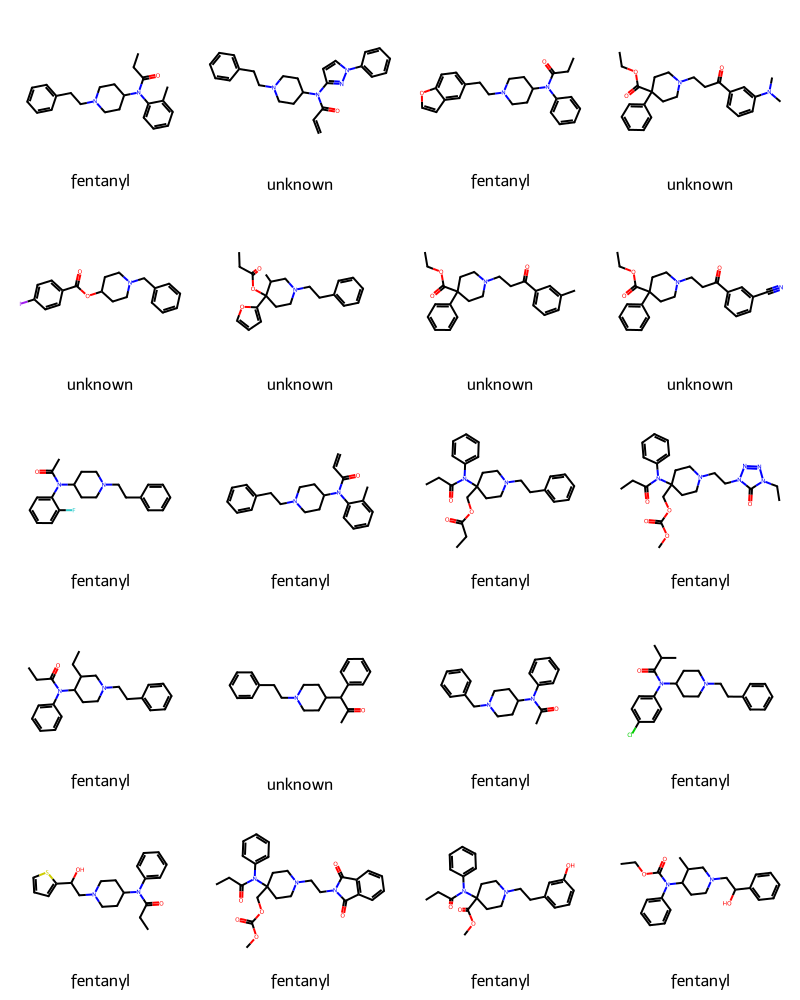

In [18]:
def mols_grid(df: pd.DataFrame, label: int, num_mols=20, prediction=False):
    if not prediction:
        smiles = df.loc[clusterer.labels_ == label].smiles.head(num_mols)
        labels = df.loc[clusterer.labels_ == label].category.head(num_mols)
        legends = labels
    else:
        predicted_label, probablities = prediction
        df["prediction_prob"] = [f" - HDBSCAN prob: {round(float(num), 2)}" for num in probablities]
        pred_prob = df.loc[predicted_label == label].prediction_prob.head(num_mols)
        labels = df.loc[predicted_label == label].category.head(num_mols)
        smiles = df.loc[predicted_label == label].smiles.head(num_mols)
        legends = labels + pred_prob

    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles]

    return Draw.MolsToGridImage(mols, molsPerRow=4, useSVG=True, legends=legends.to_list())

mols_grid(df, 0)
# mols_grid(val_df, 93, prediction=prediction)

In [ ]:
ibo = "CC[C@H]1C[C@@H]2C[C@H]3c4[nH]c5ccc(OC)cc5c4CC[N@@](C2)[C@@H]13"
noribo = "CC[C@H]1C[C@@H]2C[C@@H]3[C@H]1N(C2)CCC4=C3NC5=C4C=C(C=C5)O"
ketamine = "Clc1ccccc1C2(NC)CCCCC2=O"
test = "COC1=CC=C(C=C1)SCC2=C(C=C(C=C2)C(=O)O)F"
test_2 = "COC1=CC=C(C=C1)SCC2=C(C=C(C=C2)C(=O)O)Cl"
test2 = "COC1=CC=CC(=C1)COC2=C(C=CC=C2F)C(=O)O"
test2_2 = "COC1=CC=CC(=C1)COC2=C(C=CC=C2Cl)C(=O)O"
huh = "CC(C)SC1=CC=CC(=C1)C(=O)C2CCCCC2CN"
test_smiles = [ibo, noribo, ketamine, test, test_2, test2, test2_2, huh]

model = SentenceTransformer(
    "output/ChemBERTa-zinc-base-v1-zinc20-(functional)-matryoshka-embeddings-AnglELoss-2024-04-08_16-39-31",
    device="cuda",
    truncate_dim = 16
)

smiles_embeddings: np.ndarray = model.encode(  # type: ignore
    test_smiles,
    batch_size=4096,
    show_progress_bar=True,
    convert_to_numpy=True,
    device="cuda",
    normalize_embeddings=True,
)

# smiles_embeddings = smiles_embeddings.astype(np.float16)

In [ ]:
# soft_clusters = all_points_membership_vectors(clusterer)
prediction = approximate_predict(clusterer, smiles_embeddings)

In [ ]:
prediction

In [ ]:
pd.Series(clusterer.labels_).value_counts()

In [ ]:
original_dataset = "data/chem/druglike_QED-Pfizer_13M.parquet"
df = pd.read_parquet(original_dataset)

In [ ]:
i =   127603                 
smiles = df.loc[clusterer.labels_ == i].smiles.head(20)

mols = [Chem.MolFromSmiles(smiles) for smiles in smiles]

Draw.MolsToGridImage(mols, molsPerRow=5, useSVG=True)

In [ ]:
test_mol = Chem.MolFromSmiles("CC(C)SC1=CC=CC(=C1)C(=O)C2CCCCC2CN")
Draw.MolsToGridImage([test_mol], molsPerRow=1)

In [ ]:
smiles